##  Classification of Stayed/Churned Customers

### Dataset description

The Customer Churn table contains information on all 3,757 customers from a Telecommunications company in California in Q2 2022. 
The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

<center>

![COVER](data/dataset-cover.png "COVER")

</center>

We first **import** all **the packages** that are needed.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing

Change some global settings for layout purposes.

In [2]:
# if you are in the jupyter notebook environment you can change the 'inline' option with 'notebook' to get interactive plots
%matplotlib notebook
# change the limit on the line length and crop to 0 very small numbers, for clearer printing
np.set_printoptions(linewidth=500, suppress=True)

## A) Perceptron
In the following cells we will **implement** the **perceptron** algorithm and use it to learn a halfspace.

**TO DO (A.0):** **Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [3]:
IDnumber = 1234 # YOUR_ID
np.random.seed(IDnumber)

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [4]:
def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

In [5]:
# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

In [6]:
# compute the splits
m_training = int(X.shape[0] * 0.75) 

# m_test is the number of samples in the test set (total-training)
m_test = X.shape[0] - m_training 

# X_training = instances for training set
X_training = X[:m_training,:] 
# Y_training = labels for the training set
Y_training = Y[:m_training, ] 

# X_test = instances for test set
X_test = X[m_training:, :]  
# Y_test = labels for the test set
Y_test = Y[m_training:,] 

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training = scaler.transform(X_training) 
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test = scaler.transform(X_test) 
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940

Number of night instances in test: 470
Number of day instances in test: 470
Mean of the training input data: [0. 0. 0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [-0.03859173 -0.01057507  0.05557416]
Std of the test input data: [0.96338446 0.99562818 1.0407794 ]


In [7]:
def to_homogeneous(X_training, X_test):
    # Add a 1 to each sample (homogeneous coordinates)
    X_training = np.hstack( [np.ones( (X_training.shape[0], 1) ), X_training] )
    X_test = np.hstack( [np.ones( (X_test.shape[0], 1) ), X_test] )
    
    return X_training, X_test

In [8]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.         -0.85681595  1.18553248 -0.90686994]
 [ 1.          1.33620809  1.44214767 -0.31393676]
 [ 1.          1.74998621  0.79394438 -0.01747016]
 [ 1.         -1.06370501  0.03742948  0.21970311]
 [ 1.         -0.11201533  0.25571902  1.93920935]
 [ 1.          1.50171934 -2.48373139 -0.25464344]
 [ 1.          1.29483028  0.88559266 -0.07676348]
 [ 1.          1.74998621 -1.47393398 -1.26262985]
 [ 1.         -0.73268252  0.47234223 -0.19535012]
 [ 1.          0.6741631  -1.43560833  0.45687638]]


In [9]:
def count_errors(current_w, X, Y):
    # This function:
    # computes the number of misclassified samples
    # returns the index of the first misclassified samples
    # if there are no misclassified samples, returns -1 as index
    products = list()
    for i in range(len(X)):
        a = np.dot(current_w.T,np.dot(X[i],Y[i]))
        products.append(a)
        
    pred = np.sign(products)
    wrong = np.array([True if i<=0 else False for i in pred])
    num_misclassified = wrong.sum()
    
    if num_misclassified > 0:
        index_misclassified = np.where(wrong)[0][0]

    else:
        index_misclassified = -1# signaling value for termination
    
    return num_misclassified, index_misclassified


        
def perceptron_update(current_w, x, y):
    # Place in this function the update rule of the perceptron algorithm
    # Remember that numpy arrays can be treated as generalized variables
    # therefore given array a = [1,2,3,4], the operation b = 10*a will yield
    # b = [10, 20, 30, 40]
    for i in range(len(x)):
        a = np.dot(current_w.T,np.dot(x[i],y[i]))


        if a <= 0:
            current_w = current_w+(x[i]*y[i])

    
    new_w = current_w

    return new_w
    

def perceptron_no_randomization(X, Y, max_num_iterations):
    
    # Initialize some support variables
    num_samples = X.shape[0]
    # best_errors will keep track of the best (minimum) number of errors
    # seen throughout training, used for the update of the best_w variable
    best_error = num_samples+1
    
    # Initialize the weights of the algorith with w=0
    curr_w =np.zeros(X.shape[1]) # ADD YOUR CODE HERE
    # The best_w variable will be used to keep track of the best solution
    best_w = curr_w.copy()

    # compute the number of misclassified samples and the index of the first of them
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified# ADD YOUR CODE HERE
        best_w = curr_w# ADD YOUR CODE HERE
    
    # initialize the number of iterations
    num_iter = 0
    # Main loop continue until all samples correctly classified or max # iterations reached
    # Remember that to signify that no errors were found we set index_misclassified = -1
    while index_misclassified != -1 and num_iter < max_num_iterations:

        curr_w = perceptron_update(curr_w,X,Y)

    
        per = np.random.permutation(len(X))
        X = X[per]
        Y = Y[per]
        
        # repeat the error count and best variables update
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified 
            best_w = curr_w 
        #print(num_misclassified)
        # update the iteration number
        num_iter += 1
        

        # Choose the misclassified sample with the lowest index at each iteration

    # as required, return the best error as a ratio with respect to the total number of samples
    best_error =  (best_error / len(X)) * 100 # ADD YOUR CODE HERE
    
    return best_w, best_error

In [10]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))

Training Error of perceptron (30 iterations): 26.020589279375223


In [11]:
errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = (errors / len(X_test))*100     # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))

Test Error of perceptron (30 iterations): 24.04255319148936


In [12]:
def perceptron(X, Y, max_num_iterations):
    # Use the previous function as a template to 
    # implement the random version of the perceptron algorithm
    # Initialize some support variables
    num_samples = X.shape[0]
    # best_errors will keep track of the best (minimum) number of errors
    # seen throughout training, used for the update of the best_w variable
    best_error = num_samples+1
    
    # Initialize the weights of the algorith with w=0
    curr_w =np.zeros(X.shape[1])
    # The best_w variable will be used to keep track of the best solution
    best_w = curr_w.copy()

    # compute the number of misclassified samples and the index of the first of them
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified
        best_w = curr_w
    
    
    num_iter = 0
   
    while index_misclassified != -1 and num_iter < max_num_iterations:
        
        curr_w = perceptron_update(curr_w,X,Y)

        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified 
            best_w = curr_w 
        #print(num_misclassified)
        # update the iteration number
        num_iter += 1
        

        # Choose the misclassified sample with the lowest index at each iteration

    # as required, return the best error as a ratio with respect to the total number of samples
    best_error =  (best_error / len(X)) * 100 
    
    return best_w, best_error

In [13]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))

errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = (errors / len(X_test))    # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))

Training Error of perceptron (30 iterations): 29.996450124245648
Test Error of perceptron (30 iterations): 0.31170212765957445


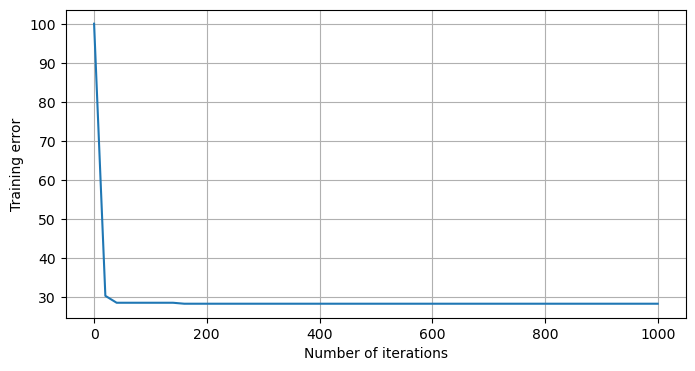

In [15]:
# Plot the loss with respect to the number of iterations
%matplotlib inline
plt.figure(figsize=(8,4))

num_iters = np.arange(0, 1001, 20)
errors = []

for num_iter in num_iters:
    _, error = perceptron(X_training, Y_training, num_iter)
    errors.append(error)

plt.plot(num_iters, errors)
plt.xlabel('Number of iterations')
plt.ylabel('Training error')
plt.grid()
plt.show()

# NOTE how the training loss decreases as we increase the number of iterations

In [16]:
w_found, error = perceptron(X_training,Y_training, 3000)  
print("Training Error of perceptron (3000 iterations): " + str(error))

num_errors, _ = count_errors(w_found, X_test,Y_test) 

true_loss_estimate = (num_errors / len(X_test))  
print("Test Error of perceptron (3000 iterations): " + str(true_loss_estimate))

Training Error of perceptron (3000 iterations): 28.328008519701807
Test Error of perceptron (3000 iterations): 0.3


In [17]:
# part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C = 1e5) # C should be very large to ignore regularization (see above)

# learn from training set: hint use fit(...)

logreg.fit(X_training,Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training) 

# print the error rate = fraction of misclassified samples
error_count_training = (predicted_training != Y_training).sum()
error_rate_training = (error_count_training / len(X_training)) * 100 
print("Error rate on training set: "+str(error_rate_training))

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()
error_rate_test =(error_count_test / len(X_test)) * 100 
print("Error rate on test set: " + str(error_rate_test))

Intercept: [-0.04674437]
Coefficients: [[-0.04674437 -1.43821763  0.88923872  0.16852066]]
Error rate on training set: 24.600638977635782
Error rate on test set: 24.893617021276597


In [18]:
feature_names  = ["Tenure in Months","Monthly Charge","Age"]

# Select the two features to use
idx0 = 0 
idx1 = 1 

X_reduced = X[:,[idx0, idx1]]

# re-initialize the dataset splits, with the reduced sets
X_training = X_reduced[:m_training,:] 
Y_training = Y[:m_training, ] 

X_test = X_reduced[m_training:, :] 
Y_test = Y[m_training:,] 

Now learn a model using the training data and measure the performances.

In [19]:
# learning from training data
# predict on test set
logreg.fit(X_training,Y_training)
predicted_test = logreg.predict(X_test) 

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()

# print the error rate = fraction of misclassified samples
error_rate_test = (error_count_test / len(X_test)) * 100 
print("Error rate on test set: " + str(error_rate_test))

Error rate on test set: 25.21276595744681
